In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Lambda, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt

2023-04-04 16:06:48.811838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train=pd.read_csv('/Users/khushm/Documents/GitHub/MINIPROJECT_CNNLBP/train.csv')
test=pd.read_csv('/Users/khushm/Documents/GitHub/MINIPROJECT_CNNLBP/test.csv')
sub=pd.read_csv('/Users/khushm/Documents/GitHub/MINIPROJECT_CNNLBP/output.csv')
emotions = ('happy', 'sad','fearful','neutral','angry','disgusted','surprised')

In [3]:
print(f"Training data size {train.shape}\nTesting data size {test.shape}")

Training data size (28709, 577)
Testing data size (7178, 576)


In [4]:
X = train.drop(['Labels'], 1).values
y = train['Labels'].values
X = X / 255.0
X = X.reshape(-1,24,24,1) #reshaping the image to 3 dimensions, canal=1 for grayscale
y = to_categorical(y) #Encoding labels to one hot vector 
print(f"Label size {y.shape}")

Label size (28709, 7)


/var/folders/m5/g2s2vm2d69s8qfj5cc66mryw0000gn/T/ipykernel_34514/2809775689.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train.drop(['Labels'], 1).values


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25838, 24, 24, 1), (2871, 24, 24, 1), (25838, 7), (2871, 7))

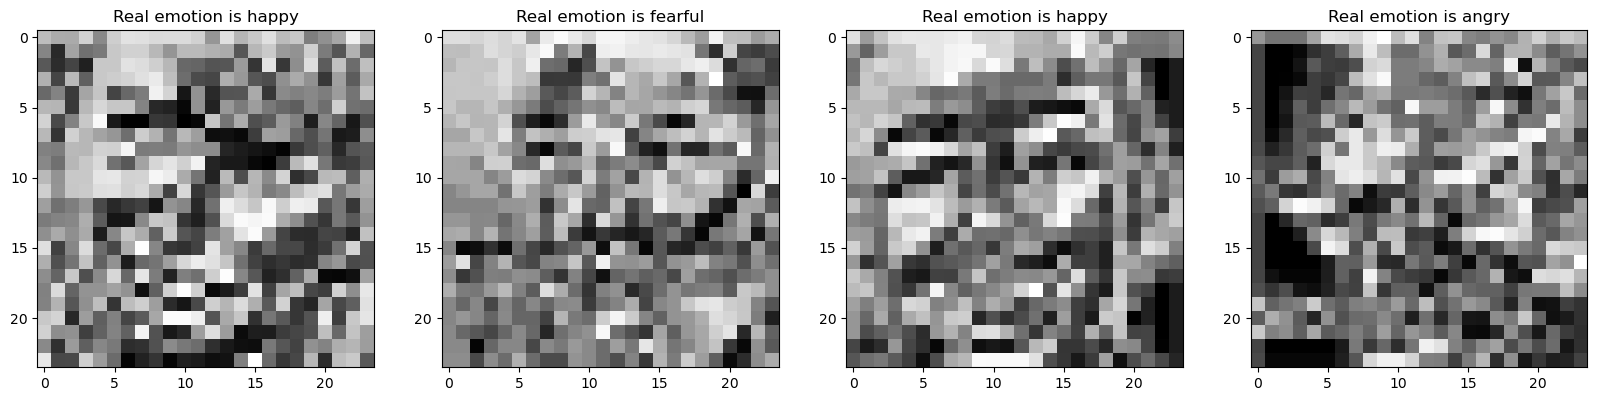

In [6]:
X_train__ = X_train.reshape(X_train.shape[0], 24, 24)
fig, axis = plt.subplots(1, 4, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train__[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Real emotion is {emotions[digit]}"); #Data visualisation

In [7]:
mean = np.mean(X_train)
std = np.std(X_train)

def standardize(x):
    return (x-mean)/std #Normalisation

In [22]:
#Defining the CNN model

model=Sequential()
   
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(24,24,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())    

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
    
model.add(Flatten())
model.add(Dense(512,activation="relu"))
    
model.add(Dense(7,activation="softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 22, 22, 64)        640       
                                                                 
 conv2d_18 (Conv2D)          (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 10, 10, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_20 (Conv2D)          (None, 6, 6, 128)        

In [23]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=120)
test_gen = datagen.flow(X_test, y_test, batch_size=120)

In [24]:
epochs = 50
batch_size = 120
train_steps = X_train.shape[0] // batch_size
valid_steps = X_test.shape[0] // batch_size

es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", # metrics to monitor
        patience=10, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

rp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.00001,
     )

In [25]:
# Fit the model
history = model.fit(train_gen, 
                              epochs = epochs, 
                              steps_per_epoch = train_steps,
                              validation_data = test_gen,
                              validation_steps = valid_steps, 
                              callbacks=[es, rp])

Epoch 1/50
215/215 [==============================] - 70s 321ms/step - loss: 1.7390 - accuracy: 0.3186 - val_loss: 2.2424 - val_accuracy: 0.1319 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 66s 307ms/step - loss: 1.5889 - accuracy: 0.3799 - val_loss: 1.7419 - val_accuracy: 0.2877 - lr: 0.0010
Epoch 3/50
215/215 [==============================] - 65s 303ms/step - loss: 1.5143 - accuracy: 0.4092 - val_loss: 1.6023 - val_accuracy: 0.3558 - lr: 0.0010
Epoch 4/50
215/215 [==============================] - 65s 301ms/step - loss: 1.4614 - accuracy: 0.4388 - val_loss: 1.6260 - val_accuracy: 0.3837 - lr: 0.0010
Epoch 5/50
215/215 [==============================] - 65s 302ms/step - loss: 1.4221 - accuracy: 0.4530 - val_loss: 1.4980 - val_accuracy: 0.4141 - lr: 0.0010
Epoch 6/50
215/215 [==============================] - 69s 319ms/step - loss: 1.3912 - accuracy: 0.4617 - val_loss: 1.5286 - val_accuracy: 0.4040 - lr: 0.0010
Epoch 7/50
215/215 [==============================] 

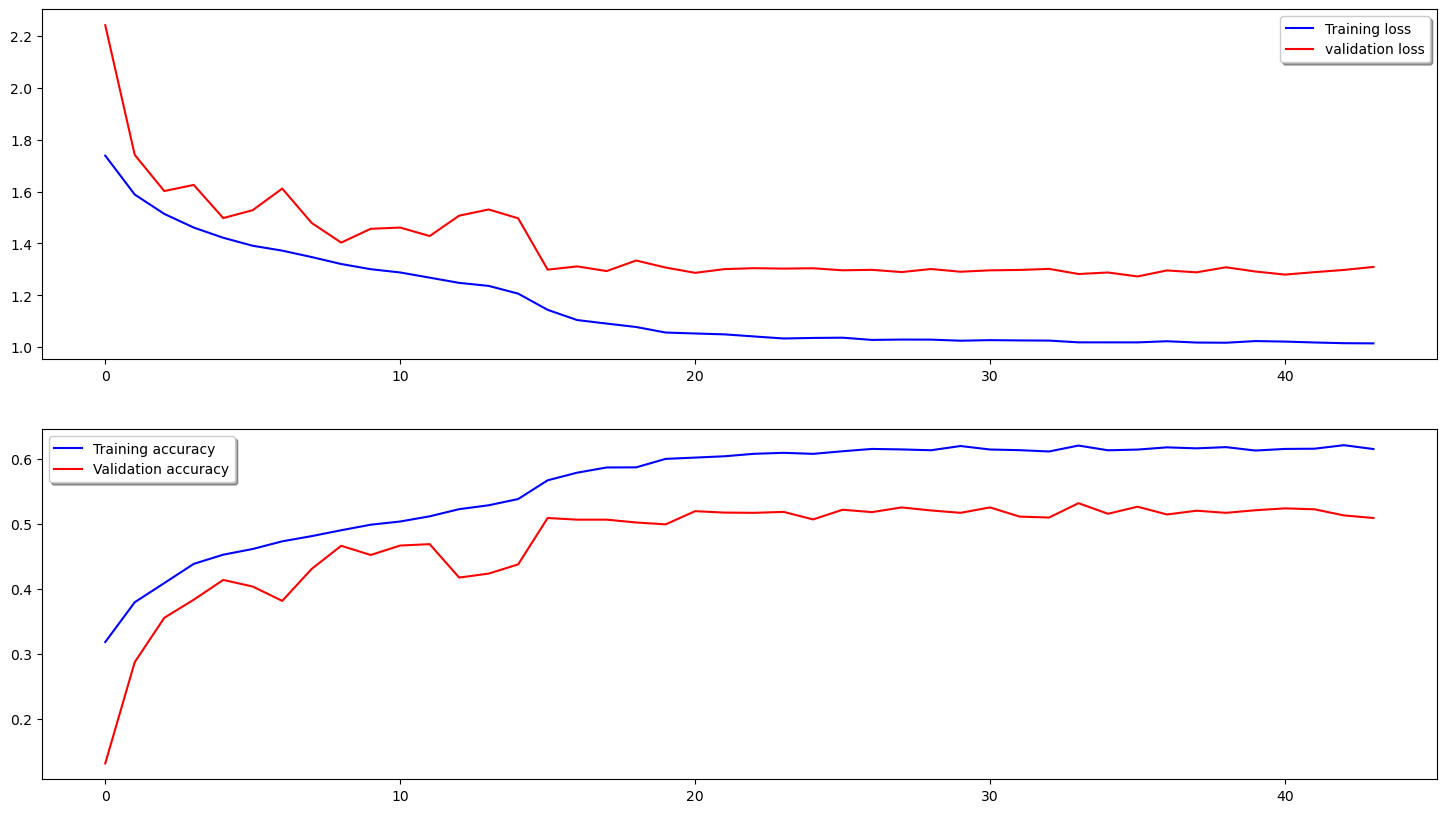

In [26]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

90/90 [==============================] - 2s 26ms/step
(2871, 7)


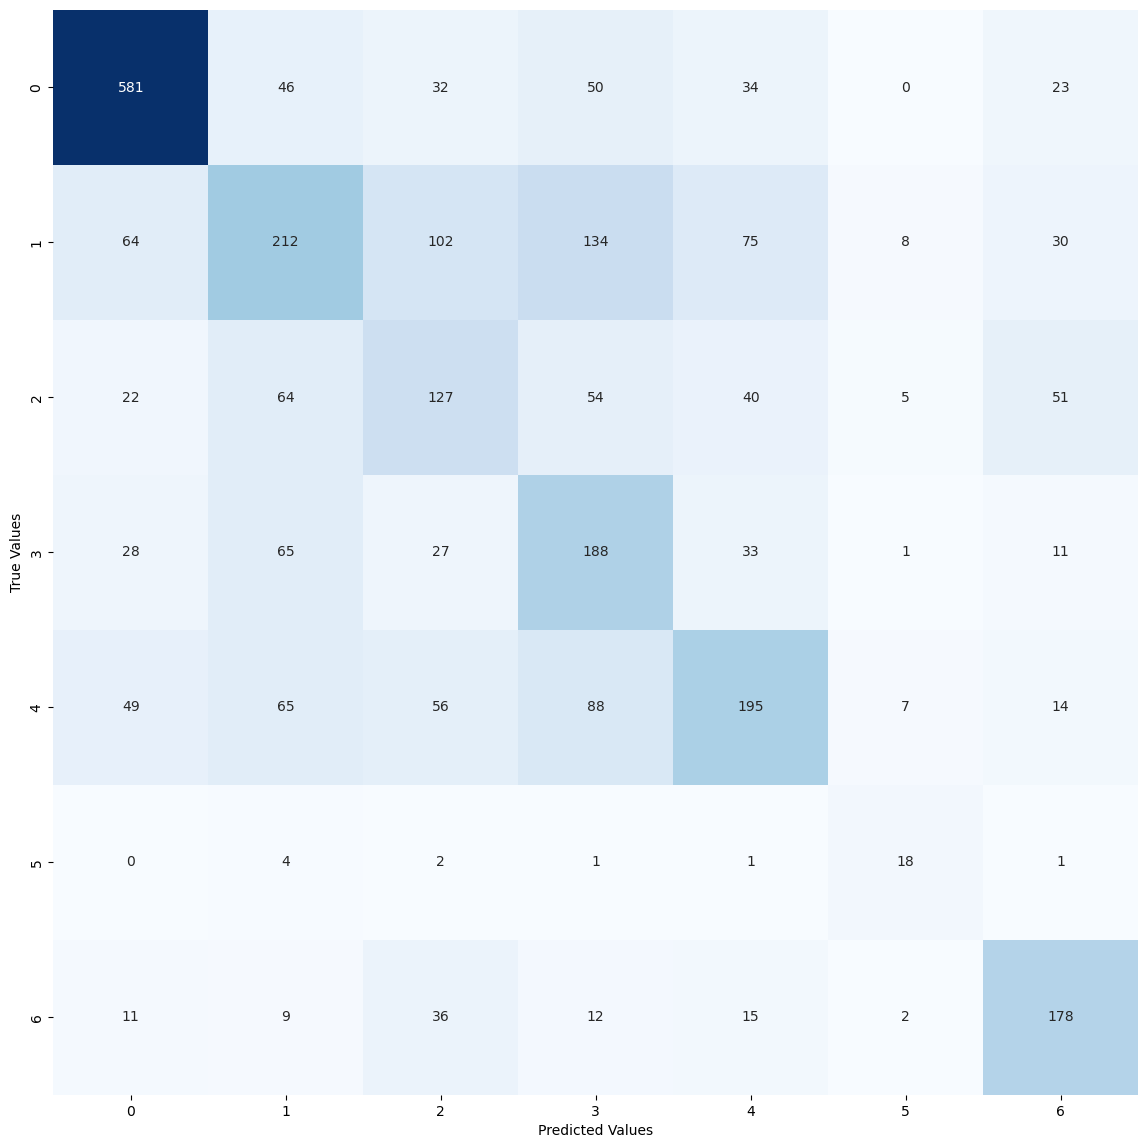

In [27]:
fig = plt.figure(figsize=(14, 18)) # Set Figure

y_pred = model.predict(X_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels
print(y_test.shape)

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

#Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

90/90 [==============================] - 2s 26ms/step


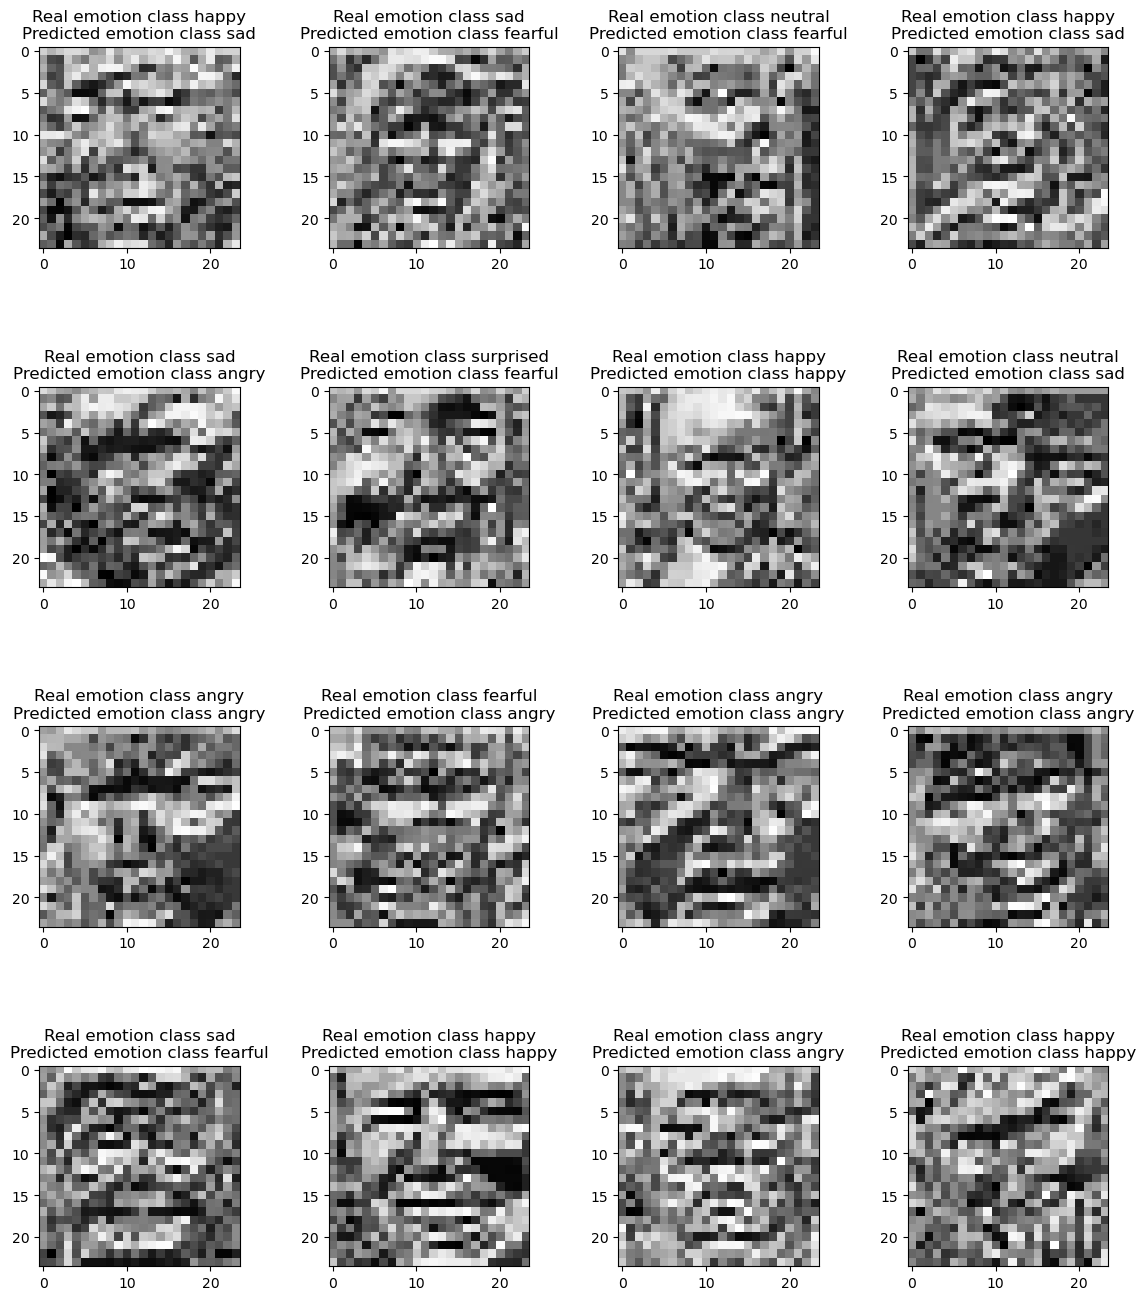

In [28]:
y_pred = model.predict(X_test)
X_test__ = X_test.reshape(X_test.shape[0], 24, 24)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
fig.tight_layout(pad=3.0)
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real emotion class {emotions[y_test[i].argmax()]}\nPredicted emotion class {emotions[y_pred[i].argmax()]}");